In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#LOADING DATA INTO PANDAS DF FROM 'zippedData/'
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv')
imdb_name_basics = pd.read_csv('zippedData/imdb.name.basics.csv')
# title_alias = pd.read_csv('zippedData/imdb.title.akas.csv') #Not Particularly useful (Title and region data)
title_basics = pd.read_csv('zippedData/imdb.title.basics.csv') #Contains Genre info and Title
title_crew = pd.read_csv('zippedData/imdb.title.crew.csv') #Contains Director ID and Writer ID
title_principals = pd.read_csv('zippedData/imdb.title.principals.csv')
title_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv')
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv', sep='\t')
reviews = pd.read_csv('zippedData/rt.reviews.tsv', sep='\t', encoding= 'unicode_escape')
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv')
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv')
print('nessisary files loaded into pandas successfully')

nessisary files loaded into pandas successfully


In [24]:
#EDA FOR SEPERATING GENRES FOR ANALYSIS
    #WORKS WITH CELL BELOW

    #FINDS UNIQUE GENRES FOR COLUMN CREATION
genre_df = title_basics['genres'].str.split(',', expand=True)
genre_df = pd.melt(genre_df)
genre_list = list(set(genre_df['value']))
genre_list.remove(np.nan)
genre_list.remove(None)

genre_col_df = pd.DataFrame(columns=genre_list)

extended_genre_df = pd.concat([title_basics, genre_col_df], axis=1)

len(extended_genre_df.columns[7:]) #NUMBER OF UNIQUE GENRE COLUMNS = 26

genre_df_filled = extended_genre_df.dropna(axis=0, subset=['genres'], inplace=False).reset_index().copy()

genre_df_filled.head(2)

,index,tconst,primary_title,original_title,start_year,runtime_minutes,genres,Short,Drama,Family,...,Romance,News,Game-Show,Animation,War,Mystery,Musical,Fantasy,Documentary,Action
0,0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#EDA SPLITS DATA ASSIGNS 1/0 TO GENRES IN COLUMNS 1=TRUE 0=FALSE
    #LOGIC WORKS TAKES A LONG TIME TO RUN
    #WORKS IN CONJUNCTION WITH CELL ABOVE
    #MUCH SLOWER COMPARED TO MELT METHOD BELOW
    
# pd.options.mode.chained_assignment = None 


#OLD METHOD FOR SEPERATING DATA. NOT USED IN ANALYSIS.
# for genre in genre_df_filled.columns[7:]:
#     for row in range(0, genre_df_filled.shape[0]): #genre_df_filled.shape[0]
#         if genre_df_filled['genres'][row] in genre:
#             genre_df_filled[genre][row] = 1
#         else:
#             genre_df_filled[genre][row] = 0

# genre_df_filled #2000x26 = 52,0000 (40s) -> 140735x26 = 3,659,110 (47mins)

In [11]:
#METHOD FOR SEPERATING GENRE DATA
#SPLITS 'GENRES' ON ',' TO CREATE NEW COLUMNS
genre_split_df = pd.concat([title_basics, title_basics['genres'].str.split(',', expand=True)], axis=1)

#GENRE COLUMNS ARE MELTED TO CREATE SOLE VALUE COLUMN TO ANALYIZE GENRE DATA 
melted_df = pd.melt(genre_split_df ,id_vars=list(title_basics.columns)).dropna(axis=0, subset=['value'])

melted_df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,variable,value
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",0,Action
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",0,Biography
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",0,Comedy
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",0,Comedy


In [12]:
#TRANSORMING DATA SET
    #RUN ONCE
movie_budgets['Year'] = movie_budgets.apply(lambda x: x['release_date'][-4:], axis=1).astype(int)
movie_budgets['production_budget'] = movie_budgets.apply(lambda x: x['production_budget'].strip('$').replace(',',''), axis=1).astype('int')
movie_budgets['worldwide_gross'] = movie_budgets.apply(lambda x: x['worldwide_gross'].strip('$').replace(',',''), axis=1).astype('int')

movie_budgets['ROI'] = (movie_budgets['worldwide_gross']-movie_budgets['production_budget'])/movie_budgets['production_budget']

#REMOVING UNNESSESARY COLUMNS
movie_budgets_mod = movie_budgets.drop(['domestic_gross', 'id'], axis=1)

movie_budgets_mod.head()

,release_date,movie,production_budget,worldwide_gross,Year,ROI
0,"Dec 18, 2009",Avatar,425000000,2776345279,2009,5.532577
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,2011,1.546673
2,"Jun 7, 2019",Dark Phoenix,350000000,149762350,2019,-0.572108
3,"May 1, 2015",Avengers: Age of Ultron,330600000,1403013963,2015,3.243841
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,1316721747,2017,3.153696


In [13]:
#FILTERS NULL DATA FOR 'worldwide_gross'
movie_budgets_mod = movie_budgets_mod[movie_budgets_mod['worldwide_gross'] != 0] #367 entries with missing gross

In [14]:
#COMBINE DATASETS BASED ON TITLE AND YEAR

#https://stackoverflow.com/questions/53549492/joining-two-pandas-dataframes-based-on-multiple-conditions
added_roi_to_melt_df = movie_budgets_mod.merge(melted_df, 
                                               how='inner', 
                                               left_on=['movie', 'Year'], 
                                               right_on=['primary_title', 'start_year'])
melt_pivot = added_roi_to_melt_df.pivot(index=['tconst', 'movie', 'Year'], 
                                        columns=['value'], 
                                        values='ROI')
genre_roi_by_year = melt_pivot.groupby(by='Year', 
                                       axis=0).median()

In [15]:
movie_budgets_mod.sort_values(by='worldwide_gross').head()

,release_date,movie,production_budget,worldwide_gross,Year,ROI
5302,"Dec 11, 2015",American Hero,1000000,26,2015,-0.999974
5335,"Nov 21, 2014",Food Chains,913000,176,2014,-0.999807
5770,"Aug 14, 2008",The Rise and Fall of Miss Thang,10000,401,2008,-0.959900
5518,"Oct 13, 2005",The Dark Hours,400000,423,2005,-0.998942
5383,"Dec 31, 2014",Destiny,750000,450,2014,-0.999400


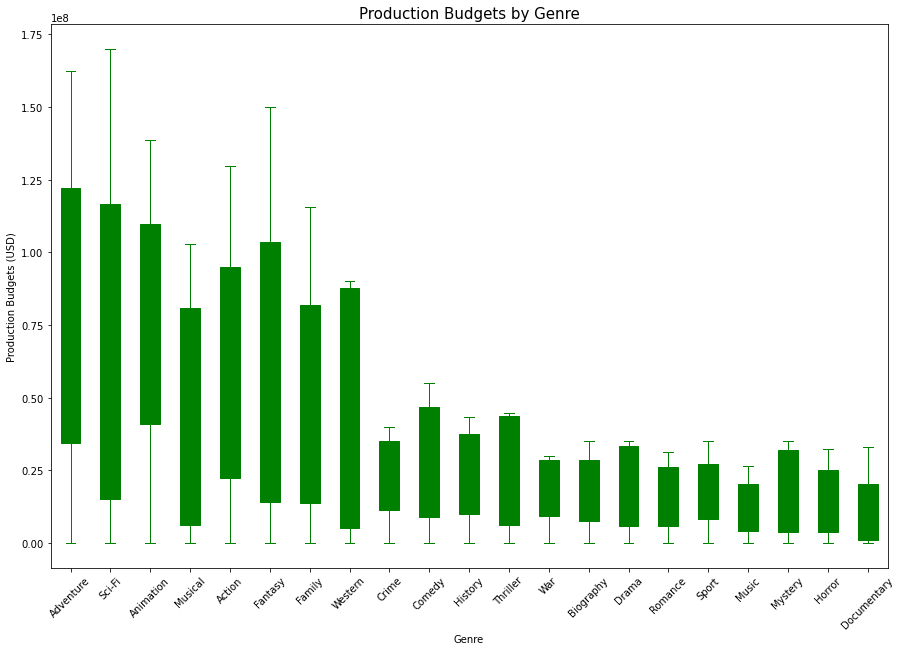

In [16]:
budget_pivot = added_roi_to_melt_df.pivot(index=['tconst', 'movie', 'Year'], 
                                          columns=['value'], 
                                          values='production_budget')
# SORTING BY MEDIAN HIGH TO LOW
median_budgets = budget_pivot.median()
median_budgets.sort_values(ascending=False, inplace=True)
budget_pivot = budget_pivot[median_budgets.index]
# CREATING DETAILS FOR THE FIGURE
budget_boxplot = budget_pivot.describe().boxplot(figsize=(15,10), 
                                                 rot=45, 
                                                 showfliers=False, 
                                                 color='green', 
                                                 patch_artist=True, 
                                                 grid=False)
budget_boxplot.set_title('Production Budgets by Genre', fontsize=15)
budget_boxplot.set_ylabel('Production Budgets (USD)')
budget_boxplot.set_xlabel('Genre');

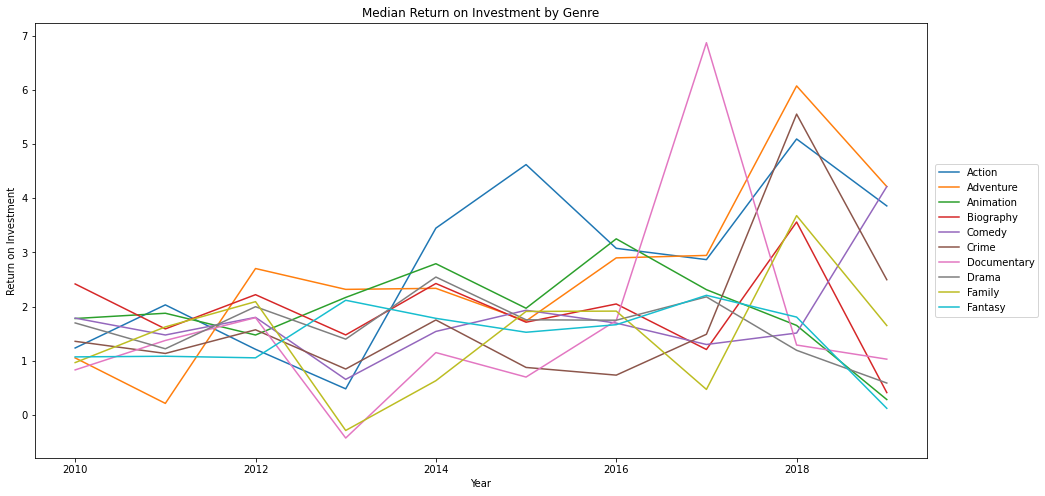

In [18]:
#TODOS -- CHANGE LABEL TO INCLUDES 2019 ENDPOINT
top_10_roi_genres = genre_roi_by_year.sum().sort_values(ascending=False)[0:10].index

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(genre_roi_by_year[top_10_roi_genres])

ax.legend(genre_roi_by_year, loc='right', bbox_to_anchor=(1.13, .5))

ax.set_xlabel("Year")
ax.set_ylabel("Return on Investment")
ax.set_title("Median Return on Investment by Genre");

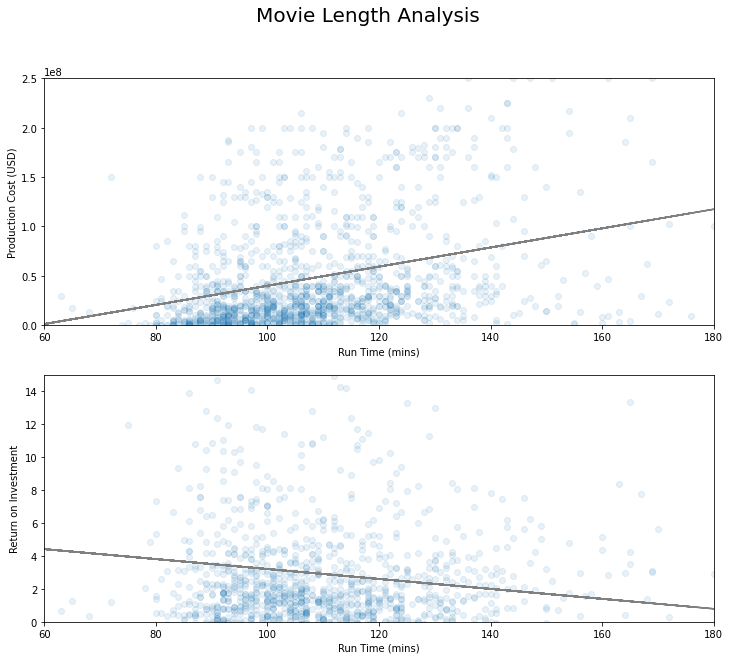

In [22]:
runtime_df = added_roi_to_melt_df[added_roi_to_melt_df['runtime_minutes'] > 0] #shape = 3613
runtime_df = runtime_df.drop_duplicates(subset='tconst')
x_runtime = runtime_df['runtime_minutes']
y_budget = runtime_df['production_budget']
y2_roi = runtime_df['ROI']

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10))

m1, b1 = np.polyfit(x_runtime, y_budget, 1)
m2, b2 = np.polyfit(x_runtime, y2_roi, 1)

ax2.set_ylim(bottom=0, top=15)
ax1.set_ylim(bottom=0, top=250000000)
ax2.set_xlim(left=60, right=180)
ax1.set_xlim(left=60, right=180)

fig.suptitle('Movie Length Analysis', fontsize=20)

ax1.set_xlabel('Run Time (mins)')
ax1.set_ylabel('Production Cost (USD)')

ax2.set_xlabel('Run Time (mins)')
ax2.set_ylabel('Return on Investment')

ax1.scatter(x_runtime, y_budget, alpha=.1)
ax1.plot(x_runtime, m1*x_runtime + b1, c='grey')

ax2.scatter(x_runtime, y2_roi, alpha=.1)
ax2.plot(x_runtime, m2*x_runtime + b2, c='grey');

<BarContainer object of 12 artists>

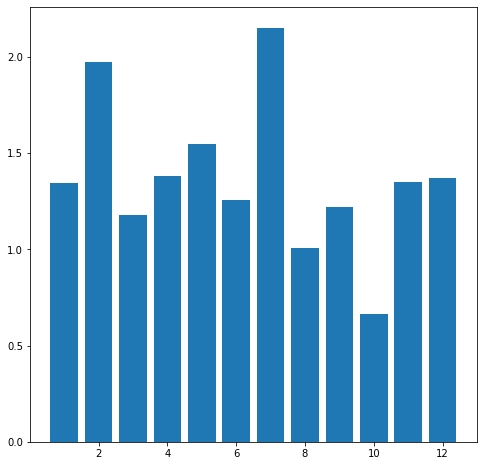

In [23]:
#CREATES PLOT OF ROI BY MONTH
#TODOS -- ADD LABEL
#TODOS -- CHANGE X AXIS TO DISPLAY MONTH(MMM) INSTEAD OF NUMBER
#TODOS -- ADD RELATIVE BARS TO SHOW # OF MOVIES RELEASED PER MONTH (NEW FIGURE OR NEW AXIS)
#TODOS -- TRY USING SEABORN TO MAKE GRAPHIC MORE INTRESTING
release_month_df = added_roi_to_melt_df
release_month_df['Release_Month'] = release_month_df.apply(lambda x: x['release_date'][0:3], axis=1)
month_analysis_df = release_month_df.groupby(by='Release_Month', axis=0)['ROI'].describe()

#USE DICT FOR MAPPING MONTH INDEX TO MONTH NAME
mon_dict = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
month_analysis_df['Month_index'] = month_analysis_df.index.map(mon_dict)

x_bar_mon = month_analysis_df['Month_index']
y_bar_mon = month_analysis_df['50%']

fig, ax = plt.subplots(figsize=(8, 8))

plt.bar(x_bar_mon, y_bar_mon)

In [44]:
#POTENTIAL DATA SET TO USE FOR ANALYIZING MOVIE RATING
movie_info['synopsis'][14]

tmdb_movies.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [47]:
movie_budgets[movie_budgets['movie'] == 'How to Train Your Dragon']

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,Year,ROI
129,30,"Mar 26, 2010",How to Train Your Dragon,165000000,"$217,581,232",494870992,2010,1.999218


In [50]:
added_roi_to_melt_df[added_roi_to_melt_df['movie'] == 'How to Train Your Dragon']

,release_date,movie,production_budget,worldwide_gross,Year,ROI,tconst,primary_title,original_title,start_year,runtime_minutes,genres,variable,value,Release_Month
264,"Mar 26, 2010",How to Train Your Dragon,165000000,494870992,2010,1.999218,tt0892769,How to Train Your Dragon,How to Train Your Dragon,2010,98.0,"Action,Adventure,Animation",0,Action,Mar
265,"Mar 26, 2010",How to Train Your Dragon,165000000,494870992,2010,1.999218,tt0892769,How to Train Your Dragon,How to Train Your Dragon,2010,98.0,"Action,Adventure,Animation",1,Adventure,Mar
266,"Mar 26, 2010",How to Train Your Dragon,165000000,494870992,2010,1.999218,tt0892769,How to Train Your Dragon,How to Train Your Dragon,2010,98.0,"Action,Adventure,Animation",2,Animation,Mar
